### Load python packages

In [1]:
import calendar
from datetime import datetime

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import shapely.wkt
import xarray as xr
from datacube import Datacube
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.waterbodies import get_waterbodies
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs, rasterize
from shapely.geometry import box

### Connect to datacube

In [2]:
# Connect to the datacube
dc = Datacube()

### Create local dask cluster

In [3]:
# Connect to local dask cluster
create_local_dask_cluster()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33717,Workers: 1
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:43851,Total threads: 4
Dashboard: /user/victoria.neema@digitalearthafrica.org/proxy/35509/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:43553,


### Analysis Parameters

In [4]:
#Using a custom bounding box here as the waterbody geometry for the Lake
# in the Waterbodies Historical Extent product includes a river.

In [5]:
# Load a custom bounding box for the water body
bbox = gpd.read_file("lakemweru.geojson").to_crs("EPSG:4326")
bbox

,geometry
0,"POLYGON ((29.16771 -8.41049, 28.31571 -8.41049..."


In [6]:
# Get the bounding box of the waterbody
# to define the area to load data for.
bbox_geom = Geometry(geom=bbox.iloc[0].geometry, crs=bbox.crs)

In [7]:
bbox_geom.explore()

## Load water quality data for the baseline period

In [8]:
# List the Lake Water Quality products available
products_df = dc.list_products()
products_df = products_df.loc[products_df["name"].str.contains("cgls_lwq")]
products_df

,name,description,license,default_crs,default_resolution
name,,,,,
cgls_lwq100_2019_2024,cgls_lwq100_2019_2024,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.000898, 0.000898)"
cgls_lwq100_2024_nrt,cgls_lwq100_2024_nrt,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.000898, 0.000898)"
cgls_lwq300_2002_2012,cgls_lwq300_2002_2012,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"
cgls_lwq300_2016_2024,cgls_lwq300_2016_2024,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"
cgls_lwq300_2024_nrt,cgls_lwq300_2024_nrt,Copernicus Global Land Service – Lake Water Qu...,None,EPSG:4326,"(-0.0022, 0.0022)"


In [9]:
# List the measurements in the Lake Water Quality products
measurements_df = dc.list_measurements()
mask = measurements_df.index.get_level_values('product').str.contains("cgls_lwq")
measurements_df = measurements_df[mask]
measurements_df

name    dtype  \
product               measurement                                               
cgls_lwq100_2019_2024 first_obs                            first_obs  float32   
                      last_obs                              last_obs  float32   
                      num_obs                                num_obs    int32   
                      trophic_state_mean          trophic_state_mean  float32   
                      turbidity_blended_mean  turbidity_blended_mean  float32   
...                                                              ...      ...   
cgls_lwq300_2024_nrt  quality_flags                    quality_flags    int32   
                      trophic_state_index        trophic_state_index  float32   
                      tsm_mean                              tsm_mean  float32   
                      tsm_uncertainty                tsm_uncertainty  float32   
                      turbidity_mean                  turbidity_mean  float32   

                                             units  \
product               measurement                    
cgls_lwq100_2019_2024 first_obs                  1   
                      last_obs                   1   
                      num_obs                    1   
                      trophic_state_mean         1   
                      turbidity_blended_mean   NTU   
...                                            ...   
cgls_lwq300_2024_nrt  quality_flags              1   
                      trophic_state_index        1   
                      tsm_mean                g/m³   
                      tsm_uncertainty            %   
                      turbidity_mean           NTU   

                                                                             nodata  \
product               measurement                                                     
cgls_lwq100_2019_2024 first_obs               9969210000000000000000000000000000000   
                      last_obs                9969210000000000000000000000000000000   
                      num_obs                                                     0   
                      trophic_state_mean      9969210000000000000000000000000000000   
                      turbidity_blended_mean  9969210000000000000000000000000000000   
...                                                                             ...   
cgls_lwq300_2024_nrt  quality_flags                                           65535   
                      trophic_state_index     9969210000000000000000000000000000000   
                      tsm_mean                9969210000000000000000000000000000000   
                      tsm_uncertainty         9969210000000000000000000000000000000   
                      turbidity_mean          9969210000000000000000000000000000000   

                                                                 aliases  \
product               measurement                                          
cgls_lwq100_2019_2024 first_obs                                      NaN   
                      last_obs                                       NaN   
                      num_obs                                        NaN   
                      trophic_state_mean      [trophic_state_index, TSI]   
                      turbidity_blended_mean                 [turbidity]   
...                                                                  ...   
cgls_lwq300_2024_nrt  quality_flags                                  NaN   
                      trophic_state_index                          [TSI]   
                      tsm_mean                                     [TSM]   
                      tsm_uncertainty                                NaN   
                      turbidity_mean                         [turbidity]   

                                             flags_definition  add_offset  \
product               measurement                                           
cgls_lwq100_2019_2024 first_obs 

In [10]:
# Select the products and measurements to load for the baseline period.
products = ["cgls_lwq300_2002_2012"]
measurements = ["TSI", "turbidity"]

In [11]:
# Load trophic state and turbidity data for the baseline period
baseline_ds = dc.load(product=products,
                      measurements=measurements,
                      # dask_chunks=dict(x=500,y=500),
                      geopolygon=bbox_geom,
                      output_crs="EPSG:6933",
                      resolution=(-300,300),
                      time=("2006", "2010"))
baseline_ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2006-01-05T23:59:59.500000 ... 201...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
    turbidity    (time, y, x) float32 97MB 9.969e+36 9.969e+36 ... 9.969e+36
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [12]:
# Mask no data in the trophic_state_index and turbidity bands
var = "TSI"
baseline_ds[var] = baseline_ds[var].where(baseline_ds[var]!=float(baseline_ds[var].nodata))

var = "turbidity"
baseline_ds[var] = baseline_ds[var].where(baseline_ds[var]!=float(baseline_ds[var].nodata))

baseline_ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2006-01-05T23:59:59.500000 ... 201...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [13]:
# Check the max data values are reasonable
# to ensure the no data value has been masked
baseline_ds.max()

<xarray.Dataset> Size: 20B
Dimensions:      ()
Coordinates:
    spatial_ref  int32 4B 6933
Data variables:
    TSI          float64 8B 100.0
    turbidity    float64 8B 433.2

In [14]:
# For each pixel and for each month count the number of valid observations
baseline_valid_observations_count = (~baseline_ds.isnull()).astype(int).resample(time="1ME").sum()
baseline_valid_observations_count

<xarray.Dataset> Size: 129MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2006-01-31 2006-02-28 ... 2010-12-31
Data variables:
    TSI          (time, y, x) int64 65MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    turbidity    (time, y, x) int64 65MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [15]:
# Resample the baseline period data to a monthly timeseries
baseline_monthly_timeseries = baseline_ds.resample(time="1ME").mean()
baseline_monthly_timeseries

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2006-01-31 2006-02-28 ... 2010-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [16]:
%%time
# Compute if using dask 
baseline_monthly_timeseries = baseline_monthly_timeseries.compute()
baseline_monthly_timeseries

CPU times: user 198 μs, sys: 0 ns, total: 198 μs
Wall time: 204 μs


<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2006-01-31 2006-02-28 ... 2010-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

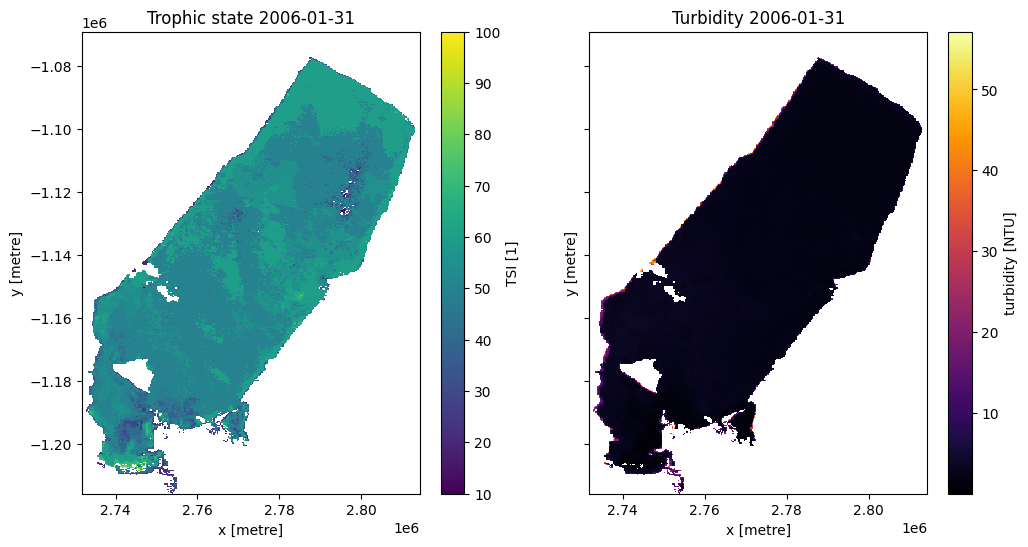

In [17]:
# Plot the trophic state and turbidity for a single time step.
to_plot = baseline_monthly_timeseries.isel(time=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)
to_plot["TSI"].plot(ax=ax[0], cmap="viridis")
ax[0].set_title(f"Trophic state {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno")
ax[1].set_title(f"Turbidity {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

In [18]:
# Get the long term mean for each month
baseline_monthly_long_term_mean = baseline_monthly_timeseries.groupby("time.month").mean()
baseline_monthly_long_term_mean

<xarray.Dataset> Size: 13MB
Dimensions:      (month: 12, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TSI          (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    turbidity    (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

In [19]:
%%time
# Compute if using dask 
baseline_monthly_long_term_mean = baseline_monthly_long_term_mean.compute()
baseline_monthly_long_term_mean

CPU times: user 182 μs, sys: 0 ns, total: 182 μs
Wall time: 186 μs


<xarray.Dataset> Size: 13MB
Dimensions:      (month: 12, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TSI          (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
    turbidity    (month, y, x) float32 6MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Load water quality data for the analysis period

In [20]:
# Select the products and measurements to load data for the baseline period.
measurements = ["TSI", "turbidity"]

In [21]:
ds = dc.load(product=["cgls_lwq300_2016_2024"],
               measurements=measurements,
               # dask_chunks=dict(x=500,y=500),
               like=baseline_ds.odc.geobox,
               time=("2017", "2021"))

# Mask no data in the trophic_state_index and turbidity bands
var = "TSI"
ds[var] = ds[var].where(ds[var]!=float(ds[var].nodata))

var = "turbidity"
ds[var] = ds[var].where(ds[var]!=float(ds[var].nodata))

ds

<xarray.Dataset> Size: 194MB
Dimensions:      (time: 180, y: 489, x: 275)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2017-01-05T23:59:59.500000 ... 202...
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
Data variables:
    TSI          (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 97MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

In [22]:
# Check the max data values are reasonable
# to ensure the no data value has been masked
ds.max()

<xarray.Dataset> Size: 20B
Dimensions:      ()
Coordinates:
    spatial_ref  int32 4B 6933
Data variables:
    TSI          float64 8B 100.0
    turbidity    float64 8B 258.9

In [23]:
# Resample the dekadal data to a monthly timeseries
monthly_timeseries = ds.resample(time="1ME").mean()
monthly_timeseries

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

In [24]:
%%time
# Compute if using dask
monthly_timeseries = monthly_timeseries.compute()
monthly_timeseries

CPU times: user 123 μs, sys: 73 μs, total: 196 μs
Wall time: 200 μs


<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 8...
    grid_mapping:  spatial_ref

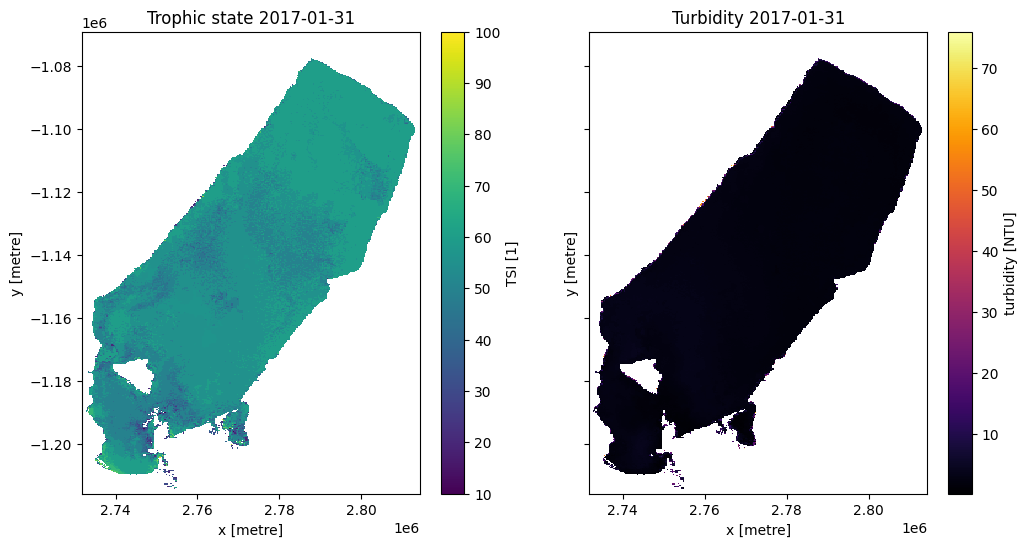

In [25]:
# Plot the turbidity and trophic state for a single time step
to_plot = monthly_timeseries.isel(time=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

to_plot["TSI"].plot(ax=ax[0], cmap="viridis")
ax[0].set_title(f"Trophic state {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno")
ax[1].set_title(f"Turbidity {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

## Calculate the monthly deviations

In [26]:
def get_monthly_deviations(x):
    # This does not change the pixel values as
    # the data is a monthly timeseries already.
    # This is to get the coordinates of the dataset to 
    # match coordinates in baseline_monthly_long_term_mean
    monthly_averages = x.groupby("time.month").mean()
    # Calculate deviation
    monthly_deviations = ((monthly_averages - baseline_monthly_long_term_mean) / baseline_monthly_long_term_mean) * 100
    return monthly_deviations

In [27]:
# Get the monthly deviations
monthly_deviations = monthly_timeseries.groupby("time.year").map(get_monthly_deviations)

# Rework back to time coordinate instead of year and month
# as seperate coordinates
years = monthly_deviations.year.values
months = monthly_deviations.month.values

stack = []
for year in years:
    for month in months:
        time_coord = np.datetime64(datetime(year, month, calendar.monthrange(year, month)[1]), "ns")
        ds_sel = monthly_deviations.sel(year=year, month=month).drop_vars(["year", "month"])
        ds_sel = ds_sel.assign_coords(coords={"time": time_coord}).expand_dims(dim={"time": 1})
        stack.append(ds_sel)   

monthly_deviations = xr.concat(stack, dim="time")
monthly_deviations

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan

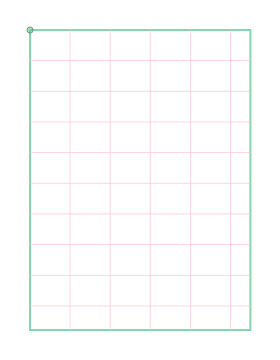

In [28]:
# Add a geobox to the monthly deviations dataset.
monthly_deviations = assign_crs(monthly_deviations, monthly_deviations["spatial_ref"].attrs["spatial_ref"])
monthly_deviations.odc.geobox

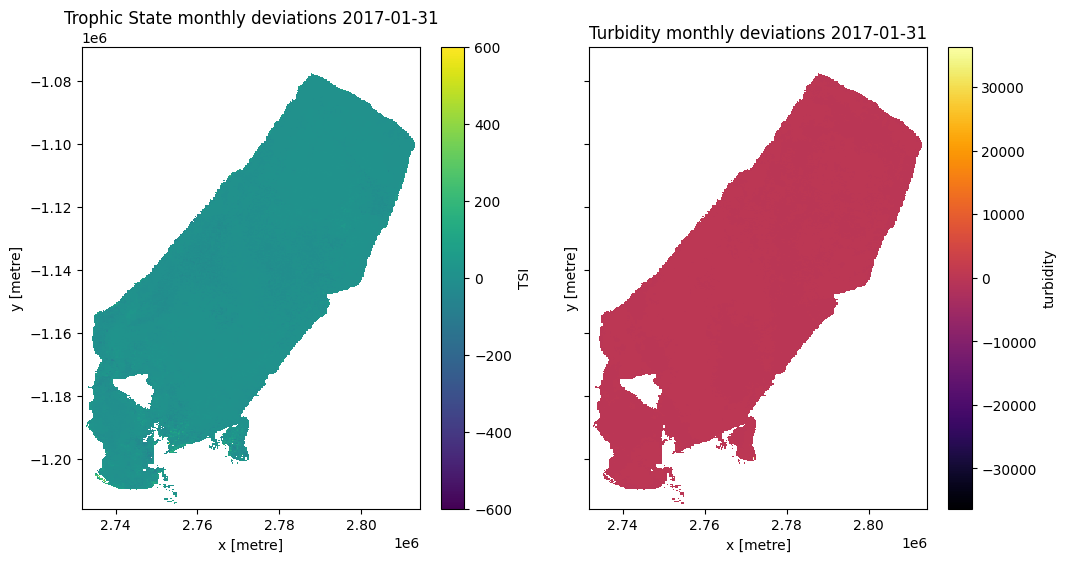

In [29]:
# Plot the trophic state and turbidity deviations
# for a single timestep
to_plot = monthly_deviations.isel(time=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

to_plot["TSI"].plot(ax=ax[0], cmap="viridis")
ax[0].set_title(f"Trophic State monthly deviations {to_plot.time.values.astype('datetime64[D]')}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno")
ax[1].set_title(f"Turbidity monthly deviations {to_plot.time.values.astype('datetime64[D]')}")
plt.show();

In [30]:
# Create an empty dataset to store the deviation classes for the monthly dataset.
monthly_deviation_classes = xr.full_like(monthly_deviations, fill_value=np.nan)
monthly_deviation_classes 

<xarray.Dataset> Size: 65MB
Dimensions:      (time: 60, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31
Data variables:
    TSI          (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan
    turbidity    (time, y, x) float32 32MB nan nan nan nan ... nan nan nan nan

In [31]:
# Categorize the trophic state index monthly deviations into the following categories:
var = "TSI"

conditions = [(monthly_deviations[var] <= 25), 
              ((monthly_deviations[var] > 25) & (monthly_deviations[var] <= 50)),
              ((monthly_deviations[var] > 50) & (monthly_deviations[var] <= 100)),
              (monthly_deviations[var] > 100)]

classes = [1,2,3,4]
monthly_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
monthly_deviation_classes[var]

<xarray.DataArray 'TSI' (time: 60, y: 489, x: 275)> Size: 65MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31

In [32]:
# Categorize the turbidity monthly deviations into the following categories:
var = "turbidity"

conditions = [(monthly_deviations[var] <= 25), 
              ((monthly_deviations[var] > 25) & (monthly_deviations[var] <= 50)),
              ((monthly_deviations[var] > 50) & (monthly_deviations[var] <= 100)),
              (monthly_deviations[var] > 100)]

classes = [1,2,3,4]
monthly_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
monthly_deviation_classes[var]

<xarray.DataArray 'turbidity' (time: 60, y: 489, x: 275)> Size: 65MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 480B 2017-01-31 2017-02-28 ... 2021-12-31

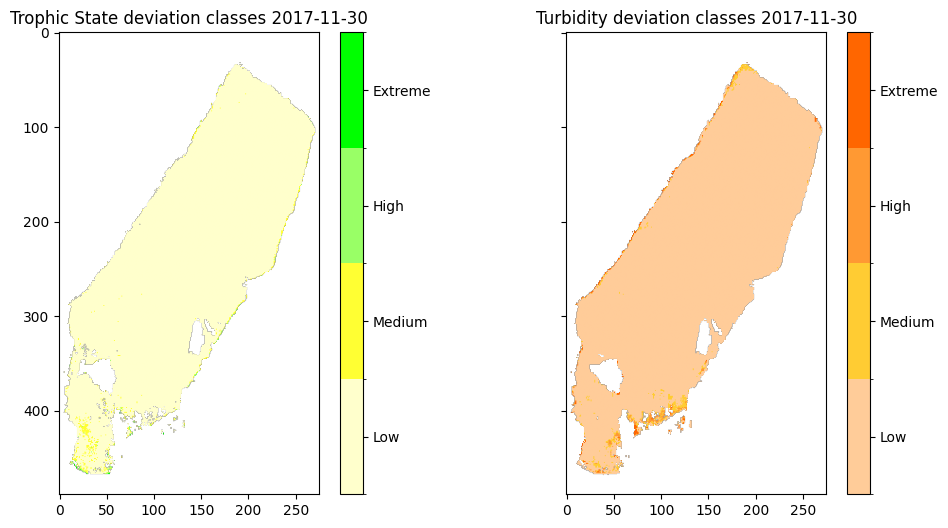

In [33]:
# Plot the deviation classes for  a single time step
to_plot = monthly_deviation_classes.isel(time=10)

classes = [1,2,3,4]
class_labels = ['Low', 'Medium', 'High', 'Extreme']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

colors = ["#FFFFCC","#FFFF33", "#99FF66", "#00FF00" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[0].imshow(to_plot["TSI"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[0].set_title(f"Trophic State deviation classes {to_plot.time.values.astype('datetime64[D]')}")


colors = ["#FFCC99","#FFCC33", "#FF9933", "#FF6600" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[1].imshow(to_plot["turbidity"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[1].set_title(f"Turbidity deviation classes {to_plot.time.values.astype('datetime64[D]')}")

plt.show();

## Summarize the monthly statistics per waterbody

In [34]:
# Get the relative share of pixels falling within each deviation category
monthly_valid_pixels_count = (~monthly_deviations.isnull()).astype(int).sum(dim=["x", "y"])
monthly_low_count = (monthly_deviation_classes == 1).astype(int).sum(dim=["x", "y"])
monthly_medium_count = (monthly_deviation_classes == 2).astype(int).sum(dim=["x", "y"])
monthly_high_count = (monthly_deviation_classes == 3).astype(int).sum(dim=["x", "y"])
monthly_extreme_count = (monthly_deviation_classes == 4).astype(int).sum(dim=["x", "y"])

In [35]:
monthly_low_perc = (monthly_low_count / monthly_valid_pixels_count) * 100
monthly_medium_perc = (monthly_medium_count / monthly_valid_pixels_count) * 100
monthly_high_perc = (monthly_high_count / monthly_valid_pixels_count) * 100
monthly_extreme_perc = (monthly_extreme_count / monthly_valid_pixels_count) * 100

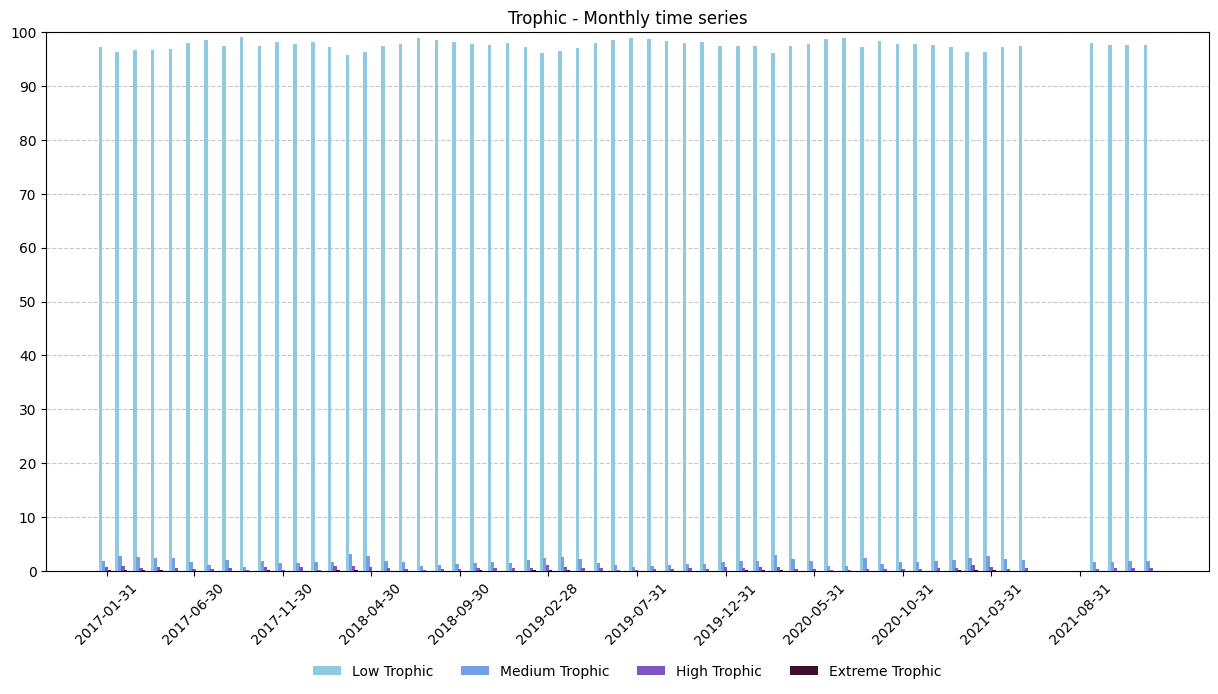

In [36]:
## X- axis
# Get the x values to use in the plot.
x = matplotlib.dates.date2num(monthly_valid_pixels_count.time.values)
# Convert to string to use as x axis labels.
x_labels = list(np.datetime_as_string(monthly_valid_pixels_count.time.values, unit='D'))
# Prevent crowding in the x axis.
rolling_step = 5
# Size of bars
bar_width = 6

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))
               
# Plot
var = "TSI"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - 10, monthly_low_perc[var].values, width=bar_width, align='center', color="#90C9E0", label="Low Trophic", zorder=3)
ax.bar(x - 5, monthly_medium_perc[var].values, width=bar_width, align='center', color="#749FE4", label="Medium Trophic", zorder=3)
ax.bar(x, monthly_high_perc[var].values, width=bar_width, align='center', color="#7D56C1", label="High Trophic", zorder=3)
ax.bar(x + 5, monthly_extreme_perc[var].values, width=bar_width, align='center', color="#3F0F2D", label="Extreme Trophic", zorder=3)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,                       
    frameon=False)

# Enable horizontal grid lines at y-ticks
ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
ax.set_xticks(ticks=x[::rolling_step], labels=x_labels[::rolling_step], rotation=45)
plt.title("Trophic - Monthly time series")
plt.show();

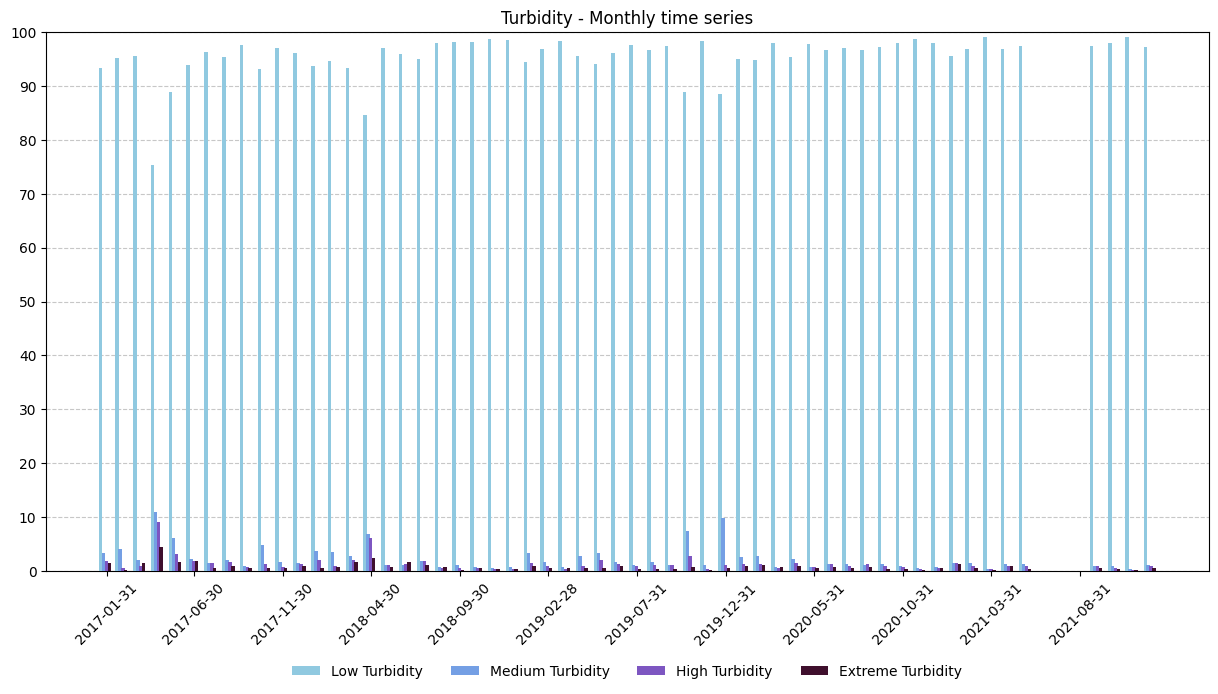

In [37]:
## X- axis
# Get the x values to use in the plot.
x = matplotlib.dates.date2num(monthly_valid_pixels_count.time.values)
# Convert to string to use as x axis labels.
x_labels = list(np.datetime_as_string(monthly_valid_pixels_count.time.values, unit='D'))
# Prevent crowding in the x axis.
rolling_step = 5
# Size of bars
bar_width = 6

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))
               
# Plot
var = "turbidity"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(x - 10, monthly_low_perc[var].values, width=bar_width, align='center', color="#90C9E0", label="Low Turbidity", zorder=3)
ax.bar(x - 5, monthly_medium_perc[var].values, width=bar_width, align='center', color="#749FE4", label="Medium Turbidity", zorder=3)
ax.bar(x, monthly_high_perc[var].values, width=bar_width, align='center', color="#7D56C1", label="High Turbidity", zorder=3)
ax.bar(x + 5, monthly_extreme_perc[var].values, width=bar_width, align='center', color="#3F0F2D", label="Extreme Turbidity", zorder=3)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.15),  
    ncol=4,                      
    frameon=False                
)

ax.grid(True, axis='y', linestyle='--', alpha=0.7, zorder=0)
ax.set_xticks(ticks=x[::rolling_step], labels=x_labels[::rolling_step], rotation=45)
plt.title("Turbidity - Monthly time series")
plt.show();

## Calculate the annual deviations

In [38]:
annual_deviations = monthly_deviations.groupby("time.year").mean()
annual_deviations

<xarray.Dataset> Size: 5MB
Dimensions:      (year: 5, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021
Data variables:
    TSI          (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    turbidity    (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

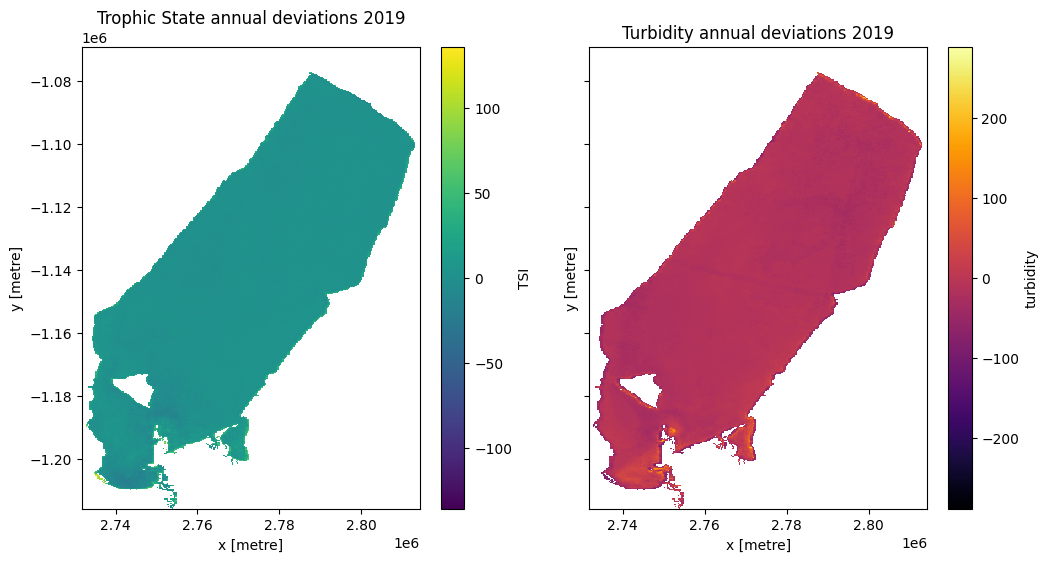

In [39]:
# Plot the trophic state and turbidity deviations
# for a single year
to_plot = annual_deviations.isel(year=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

to_plot["TSI"].plot(ax=ax[0], cmap="viridis")
ax[0].set_title(f"Trophic State annual deviations {to_plot.year.values}")

to_plot["turbidity"].plot(ax=ax[1], cmap="inferno")
ax[1].set_title(f"Turbidity annual deviations {to_plot.year.values}")
plt.show();

In [40]:
# Create an empty dataset to store the deviation classes for the annual dataset.
annual_deviation_classes = xr.full_like(annual_deviations, fill_value=np.nan)
annual_deviation_classes 

<xarray.Dataset> Size: 5MB
Dimensions:      (year: 5, y: 489, x: 275)
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021
Data variables:
    TSI          (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan
    turbidity    (year, y, x) float32 3MB nan nan nan nan ... nan nan nan nan

In [41]:
# Categorize the trophic state index annual deviations into the following categories:
# < 25% (low, 1), 25-50% (medium, 2), 50-100% (high, 3), > 100% (extreme, 4)
var = "TSI"

conditions = [(annual_deviations[var] <= 25), 
              ((annual_deviations[var] > 25) & (annual_deviations[var] <= 50)),
              ((annual_deviations[var] > 50) & (annual_deviations[var] <= 100)),
              (annual_deviations[var] > 100)
             ]

classes = [1,2,3,4]
annual_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
annual_deviation_classes[var]

<xarray.DataArray 'TSI' (year: 5, y: 489, x: 275)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021

In [42]:
# Categorize the turbidity annual deviations into the following categories:
# < 25% (low, 1), 25-50% (medium, 2), 50-100% (high, 3), > 100% (extreme, 4)

var = "turbidity"

conditions = [(annual_deviations[var] <= 25), 
              ((annual_deviations[var] > 25) & (annual_deviations[var] <= 50)),
              ((annual_deviations[var] > 50) & (annual_deviations[var] <= 100)),
              (annual_deviations[var] > 100)
             ]

classes = [1,2,3,4]
annual_deviation_classes[var].data = np.select(conditions, classes, default=np.nan)
annual_deviation_classes[var]

<xarray.DataArray 'turbidity' (year: 5, y: 489, x: 275)> Size: 5MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 4kB -1.069e+06 -1.07e+06 ... -1.215e+06 -1.216e+06
  * x            (x) float64 2kB 2.732e+06 2.732e+06 ... 2.814e+06 2.814e+06
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021

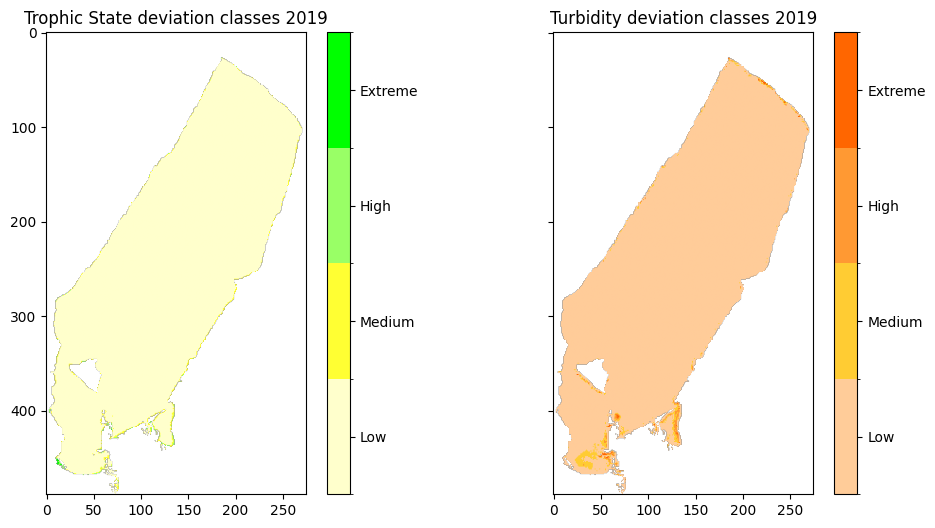

In [43]:
# Plot the deviation classes for a single time step
to_plot = annual_deviation_classes.isel(year=2)

classes = [1,2,3,4]
class_labels = ['Low', 'Medium', 'High', 'Extreme']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

colors = ["#FFFFCC","#FFFF33", "#99FF66", "#00FF00" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[0].imshow(to_plot["TSI"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[0].set_title(f"Trophic State deviation classes {to_plot.year.values}")


colors = ["#FFCC99","#FFCC33", "#FF9933", "#FF6600" ]
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(min(classes), max(classes)+2)-0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = ax[1].imshow(to_plot["turbidity"], cmap=cmap, norm=norm)
cb = plt.colorbar(im, ticks=classes)
cb.ax.set_yticklabels(class_labels)
ax[1].set_title(f"Turbidity deviation classes {to_plot.year.values}")

plt.show();

## Summarize the annual statistics per waterbody

In [44]:
# For each year get the count of pixels in each deviation category
# for the waterbody
annual_valid_pixels_count = (~annual_deviations.isnull()).astype(int).sum(dim=["x", "y"])
annual_low_count = (annual_deviation_classes == 1).astype(int).sum(dim=["x", "y"])
annual_medium_count = (annual_deviation_classes == 2).astype(int).sum(dim=["x", "y"])
annual_high_count = (annual_deviation_classes == 3).astype(int).sum(dim=["x", "y"])
annual_extreme_count = (annual_deviation_classes == 4).astype(int).sum(dim=["x", "y"])

In [45]:
# Get the relative share of pixels falling within each deviation category
annual_low_perc = (annual_low_count / annual_valid_pixels_count) * 100
annual_medium_perc = (annual_medium_count / annual_valid_pixels_count) * 100
annual_high_perc = (annual_high_count / annual_valid_pixels_count) * 100
annual_extreme_perc = (annual_extreme_count / annual_valid_pixels_count) * 100

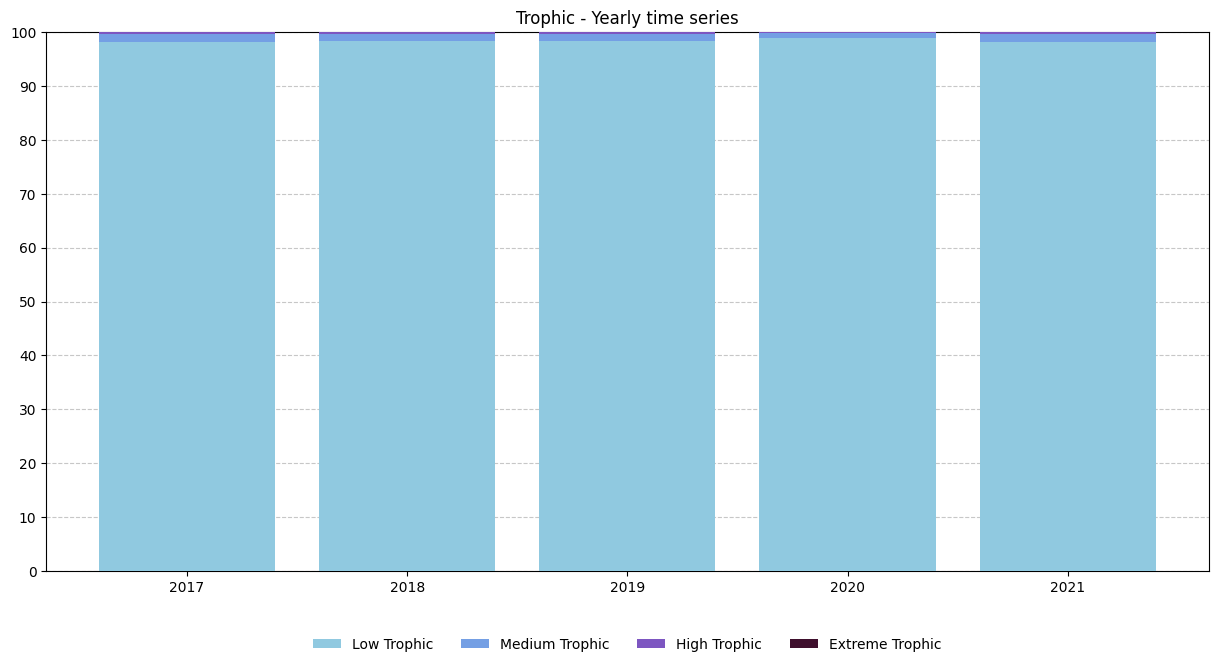

In [46]:
## X axis
years = annual_extreme_perc.year.values
bottom = np.zeros(len(years))

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))

## Plot
var = "TSI"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(years, annual_low_perc[var].values, color="#90C9E0", label="Low Trophic",  zorder=3)
ax.bar(years, annual_medium_perc[var].values, color="#749FE4", label="Medium Trophic", bottom=annual_low_perc[var].values , zorder=3)
ax.bar(years, annual_high_perc[var].values, color="#7D56C1", label="High Trophic", bottom=annual_medium_perc[var].values + annual_low_perc[var].values, zorder=3)
ax.bar(years, annual_extreme_perc[var].values, color="#3F0F2D", label="Extreme Trophic", bottom=annual_high_perc[var].values + annual_medium_perc[var].values + annual_low_perc[var].values,  zorder=3)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.10),  
    ncol=4,                       
    frameon=False)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7,  zorder=0)
plt.title("Trophic - Yearly time series")
plt.show();

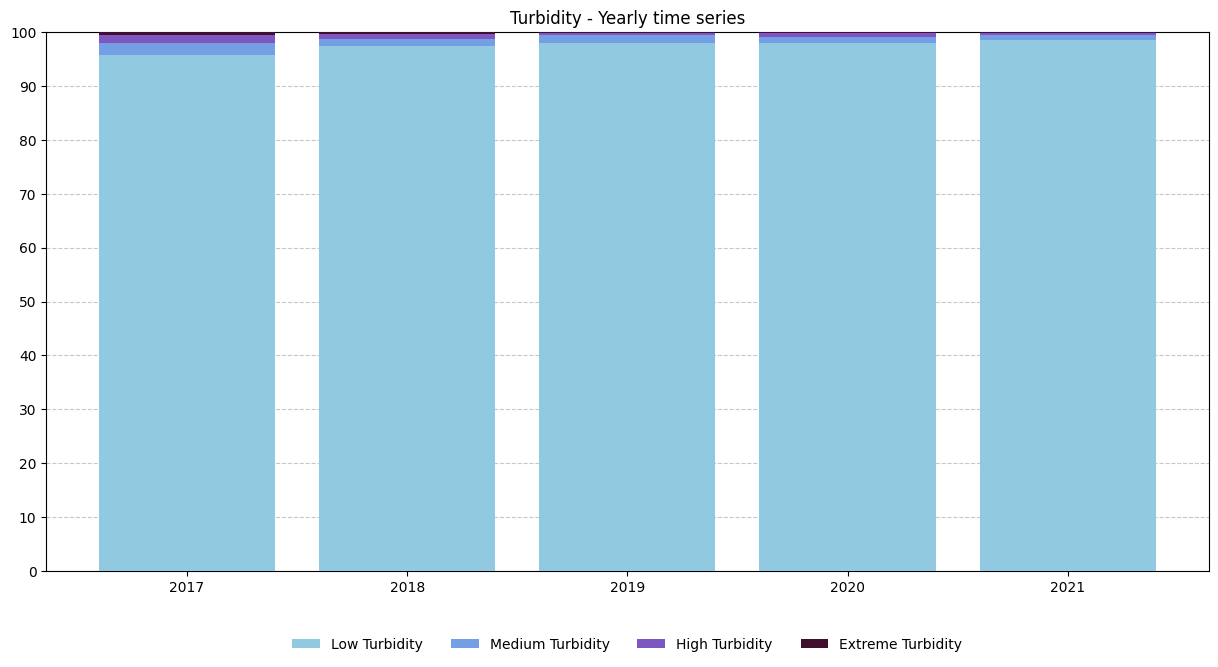

In [47]:
## X axis
years = annual_extreme_perc.year.values
bottom = np.zeros(len(years))

## Y axis 
ymin=0
ymax=100
y_ticks = list(range(ymin, ymax+1, 10))

## Plot
var = "turbidity"
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(years, annual_low_perc[var].values, color="#90C9E0", label="Low Turbidity",  zorder=3)
ax.bar(years, annual_medium_perc[var].values, color="#749FE4", label="Medium Turbidity", bottom=annual_low_perc[var].values , zorder=3)
ax.bar(years, annual_high_perc[var].values, color="#7D56C1", label="High Turbidity", bottom=annual_medium_perc[var].values + annual_low_perc[var].values, zorder=3)
ax.bar(years, annual_extreme_perc[var].values, color="#3F0F2D", label="Extreme Turbidity", bottom=annual_high_perc[var].values + annual_medium_perc[var].values + annual_low_perc[var].values,  zorder=3)

ax.legend(
    loc='upper center',           
    bbox_to_anchor=(0.5, -0.10),  
    ncol=4,                       
    frameon=False)

ax.set_ylim(ymin=ymin, ymax=ymax)
ax.set_yticks(y_ticks)
ax.grid(True, axis='y', linestyle='--', alpha=0.7,  zorder=0)
plt.title("Turbidity - Yearly time series")
plt.show();

## Waterbody classification

In [48]:
# Determine if the waterbody is affected. 
# A lake is defined as affected when the following conditions apply: 
# (high+extreme) > (low+medium)
affected = (annual_high_count + annual_extreme_count) > (annual_low_count + annual_medium_count)
affected

<xarray.Dataset> Size: 54B
Dimensions:      (year: 5)
Coordinates:
    spatial_ref  int32 4B 6933
  * year         (year) int64 40B 2017 2018 2019 2020 2021
Data variables:
    TSI          (year) bool 5B False False False False False
    turbidity    (year) bool 5B False False False False False